In [27]:
import yfinance as yf
import os
import pandas as pd
import torch 
import torch.nn as nn



In [28]:
btc = pd.read_csv("merged_btc.csv")

In [29]:
btc

,Unnamed: 0,open,high,low,close,volume,edit_count,sentiment,neg_sentiment,tomorrow,target
0,2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,5.033333,-0.232191,0.532718,424.440002,0
1,2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,5.066667,-0.232760,0.532718,394.795990,0
2,2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,5.200000,-0.235415,0.549385,408.903992,1
3,2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,5.200000,-0.233185,0.549385,398.821014,0
4,2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,5.233333,-0.204017,0.532718,402.152008,1
...,...,...,...,...,...,...,...,...,...,...,...
3704,2024-11-07 00:00:00+00:00,75637.085938,76943.117188,74480.421875,75904.859375,63467654989,0.266667,-0.004846,0.066667,76545.476562,1
3705,2024-11-08 00:00:00+00:00,75902.835938,77252.750000,75648.742188,76545.476562,55176858003,0.266667,-0.004846,0.066667,76778.867188,1
3706,2024-11-09 00:00:00+00:00,76556.187500,76932.765625,75773.789062,76778.867188,29009480361,0.300000,0.028332,0.066667,80474.187500,1
3707,2024-11-10 00:00:00+00:00,76775.546875,81474.421875,76565.429688,80474.187500,82570594495,0.433333,0.009679,0.091667,84506.726562,1


In [78]:
import warnings
warnings.filterwarnings("ignore") # why have I never done this before?

n_epochs = 1000
learning_rate = 0.001

input_size = 9
hidden_size = 128 # number of features in hidden state
num_layers =1 # number of stacked lstm layers

num_classes = 9 # number of output classes (Why do we have fifty here?) 

In [31]:
btc["tomorrow"] = btc["close"].shift(-1)
btc["target"] = (btc["tomorrow"] > btc["close"]).astype(int)
btc["target"].value_counts()

target
1    1961
0    1748
Name: count, dtype: int64

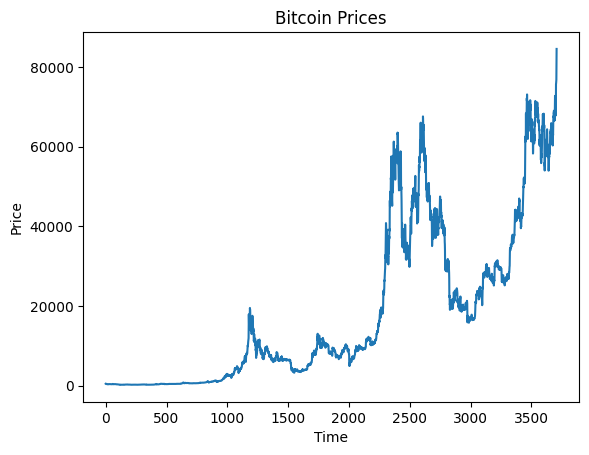

In [32]:
# plotting initial dataset
import matplotlib.pyplot as plt

plt.plot(btc.close)
plt.xlabel("Time")
plt.ylabel("Price")
plt.title("Bitcoin Prices")
plt.savefig("init_plot.png", dpi=250)
plt.show()

In [36]:
btc = btc.rename(columns={"Unnamed: 0": 'datetime'})

In [37]:
btc['datetime'] = pd.to_datetime(btc['datetime'])
btc

,datetime,open,high,low,close,volume,edit_count,sentiment,neg_sentiment,tomorrow,target
0,2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,5.033333,-0.232191,0.532718,424.440002,0
1,2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,5.066667,-0.232760,0.532718,394.795990,0
2,2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,5.200000,-0.235415,0.549385,408.903992,1
3,2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,5.200000,-0.233185,0.549385,398.821014,0
4,2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,5.233333,-0.204017,0.532718,402.152008,1
...,...,...,...,...,...,...,...,...,...,...,...
3704,2024-11-07 00:00:00+00:00,75637.085938,76943.117188,74480.421875,75904.859375,63467654989,0.266667,-0.004846,0.066667,76545.476562,1
3705,2024-11-08 00:00:00+00:00,75902.835938,77252.750000,75648.742188,76545.476562,55176858003,0.266667,-0.004846,0.066667,76778.867188,1
3706,2024-11-09 00:00:00+00:00,76556.187500,76932.765625,75773.789062,76778.867188,29009480361,0.300000,0.028332,0.066667,80474.187500,1
3707,2024-11-10 00:00:00+00:00,76775.546875,81474.421875,76565.429688,80474.187500,82570594495,0.433333,0.009679,0.091667,84506.726562,1


In [38]:
btc['datetime'] = btc['datetime'].astype(int) / 10**9

In [39]:
btc

,datetime,open,high,low,close,volume,edit_count,sentiment,neg_sentiment,tomorrow,target
0,1.410912e+09,465.864014,468.174011,452.421997,457.334015,21056800,5.033333,-0.232191,0.532718,424.440002,0
1,1.410998e+09,456.859985,456.859985,413.104004,424.440002,34483200,5.066667,-0.232760,0.532718,394.795990,0
2,1.411085e+09,424.102997,427.834991,384.532013,394.795990,37919700,5.200000,-0.235415,0.549385,408.903992,1
3,1.411171e+09,394.673004,423.295990,389.882996,408.903992,36863600,5.200000,-0.233185,0.549385,398.821014,0
4,1.411258e+09,408.084991,412.425995,393.181000,398.821014,26580100,5.233333,-0.204017,0.532718,402.152008,1
...,...,...,...,...,...,...,...,...,...,...,...
3704,1.730938e+09,75637.085938,76943.117188,74480.421875,75904.859375,63467654989,0.266667,-0.004846,0.066667,76545.476562,1
3705,1.731024e+09,75902.835938,77252.750000,75648.742188,76545.476562,55176858003,0.266667,-0.004846,0.066667,76778.867188,1
3706,1.731110e+09,76556.187500,76932.765625,75773.789062,76778.867188,29009480361,0.300000,0.028332,0.066667,80474.187500,1
3707,1.731197e+09,76775.546875,81474.421875,76565.429688,80474.187500,82570594495,0.433333,0.009679,0.091667,84506.726562,1


In [44]:
x, y = btc.drop(columns=['close','target']), btc.close.values
x.shape, y.shape

((3709, 9), (3709,))

In [46]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
mm = MinMaxScaler()
ss = StandardScaler()

x_trans = ss.fit_transform(x) ## mean of 0, std of 1
y_trans = mm.fit_transform(y.reshape(-1, 1)) # reshapes y to 'add' dimension, scales all values to range between 0 and 1

In [47]:
import numpy as np

In [53]:
# we split up the dataset so that we can pass it to the LSTM as a 'sequence'
def split_sequence(input_sequences, output_sequence, n_steps_in, n_steps_out):
    """function to split up x_train, y_train, x_test, y_test 
    to be able to be recieved by our LSTM model"""
    x, y = list(), list()
    for i in range(len(input_sequences)):
        
        # we find the end of the input and output so we can determine (since the dataset isn't by default divisible by the sequence length) 
        end_index = i + n_steps_in
        out_end_index = end_index + n_steps_out - 1
        
        if out_end_index > len(input_sequences): break
        
        x_seq, y_seq = input_sequences[i:end_index], output_sequence[end_index-1:out_end_index, -1]
        x.append(x_seq)
        y.append(y_seq)
    return np.array(x), np.array(y)

In [85]:
x_ss, y_mm = split_sequence(x_trans, y_trans, 100, num_classes)
print(x_ss.shape, y_mm.shape)

(3602, 100, 9) (3602, 9)


In [86]:
# hmmm, seems to chop off the last bit (would that be the most recent data?) Could possible improvement include making this sequence but in reverse?

In [87]:
y_mm[0]

array([0.0016709 , 0.00177663, 0.00163361, 0.00164993, 0.00159575,
       0.00157282, 0.00168496, 0.00161447, 0.00162375])

In [88]:
y_trans[99:149].squeeze(1)

array([0.0016709 , 0.00177663, 0.00163361, 0.00164993, 0.00159575,
       0.00157282, 0.00168496, 0.00161447, 0.00162375, 0.00122116,
       0.00102091, 0.0011428 , 0.00128172, 0.00137835, 0.00124805,
       0.00133175, 0.00114662, 0.00103828, 0.00106361, 0.00056633,
       0.        , 0.0003764 , 0.00035568, 0.00025089, 0.00038227,
       0.00043589, 0.00039384, 0.00057862, 0.0006558 , 0.00064955,
       0.00082705, 0.00089667, 0.00113093, 0.00101237, 0.00066184,
       0.00065707, 0.00057302, 0.00046676, 0.00057951, 0.000713  ,
       0.00058302, 0.0005781 , 0.00046257, 0.0005237 , 0.00058878,
       0.00053729, 0.00049813, 0.00049492, 0.00048717, 0.00051775])

In [89]:
total_samples = len(x)
train_test_cutoff = round(total_samples * 0.9)

x_train = x_ss[:-150]
x_test = x_ss[-150:]

y_train = y_mm[:-150]
y_test = y_mm[-150:]

print("Training shape:", x_train.shape, y_train.shape)
print("Testing shape:", x_test.shape, y_test.shape)

Training shape: (3452, 100, 9) (3452, 9)
Testing shape: (150, 100, 9) (150, 9)


In [90]:
x_train_tensor = torch.Tensor(x_train).cuda()
x_test_tensor = torch.Tensor(x_test).cuda()
y_train_tensor = torch.Tensor(y_train).cuda()
y_test_tensor = torch.Tensor(y_test).cuda()

In [91]:
x_train_tensors_final = torch.reshape(x_train_tensor,
                                      (x_train_tensor.shape[0], 100,
                                      x_train_tensor.shape[2])).cuda()
x_test_tensors_final = torch.reshape(x_test_tensor,
                                     (x_test_tensor.shape[0], 100,
                                      x_test_tensor.shape[2])).cuda()

print("Training shape:", x_train_tensors_final.shape, y_test_tensor.shape)
print("Testing shape:", x_test_tensors_final.shape, y_test_tensor.shape)

Training shape: torch.Size([3452, 100, 9]) torch.Size([150, 9])
Testing shape: torch.Size([150, 100, 9]) torch.Size([150, 9])


In [92]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [93]:
class LSTM(nn.Module):
    """LSTM model class"""
    def __init__(self, input_size, hidden_size, num_classes, num_layers=1, device=device):
        """initializes a LSTM model """
        
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
        self.num_classes = num_classes #num of classes
        self.num_layers = num_layers
        # LSTM model 
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, 
                            dropout=0.2).to(device)
        self.fc_1 = nn.Linear(hidden_size, 128).to(device)
        self.fc_2 = nn.Linear(128, num_classes).to(device)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # hidden state 
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).cuda()
        
        # propagation
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # input, hidden and internal state
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        # out = self.relu(output[:, -1, :]) # apparently you can pass either the output or the hn
        # but output seems to work if I have multiple layers and hn doesn't? Maybe I'm just not shaping it correctly? 
        hn = self.relu(hn)
        out = self.fc_1(hn) # first dense
        out = self.relu(out)
        out = self.fc_2(out) # should represent final output 
        return out

In [98]:
# define the training function 
def training_loop(n_epochs, lstm, optimizer, loss_fn, x_train, y_train, x_test, y_test):
    for epoch in range(n_epochs):
        lstm.train() # puts model in training mode (for our dropout layer this is important)
        outputs = lstm(x_train) # forward pass 
        optimizer.zero_grad() # reseting the gradients to zero before each update (otherwise it does gradient accumulation) 
        loss = loss_fn(outputs, y_train) # compute loss
        loss.backward() # backpropagation 
        optimizer.step() # update model weights using optimizer function 
        
        # if the optimizer or loss functions aren't explicitly 'tied' to the pytorch model, how does it know?
        
        lstm.eval() # switches to eval mode to do 'inferences' not training (again, for our dropout layer)
        # this implies that the test_loss is different from the loss calculated earlier
        test_preds = lstm(x_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, 
                                                                      loss.item(), 
                                                                      test_loss.item())) 
        

In [95]:
lstm = LSTM(input_size, hidden_size, num_classes, num_layers)

In [96]:
# intializing loss and optimizer function
loss_fn = torch.nn.MSELoss() # for regression? is this a regression task? 
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

In [99]:
training_loop(n_epochs, lstm, optimizer, loss_fn, x_train=x_train_tensors_final, y_train=y_train_tensor, x_test=x_test_tensors_final, y_test=y_test_tensor)

Epoch: 0, train loss: 0.00741, test loss: 0.00356
Epoch: 100, train loss: 0.00053, test loss: 0.00168
Epoch: 200, train loss: 0.00038, test loss: 0.00168
Epoch: 300, train loss: 0.00029, test loss: 0.00159
Epoch: 400, train loss: 0.00024, test loss: 0.00167
Epoch: 500, train loss: 0.00018, test loss: 0.00248
Epoch: 600, train loss: 0.00016, test loss: 0.00234
Epoch: 700, train loss: 0.00013, test loss: 0.00232
Epoch: 800, train loss: 0.00013, test loss: 0.00254
Epoch: 900, train loss: 0.00011, test loss: 0.00346


In [100]:
df_x_ss = ss.transform(btc.drop(columns=['close', 'target'])) # old transformers
# del df_x_ss["Dividends"]
# del df_x_ss["Stock Splits"]

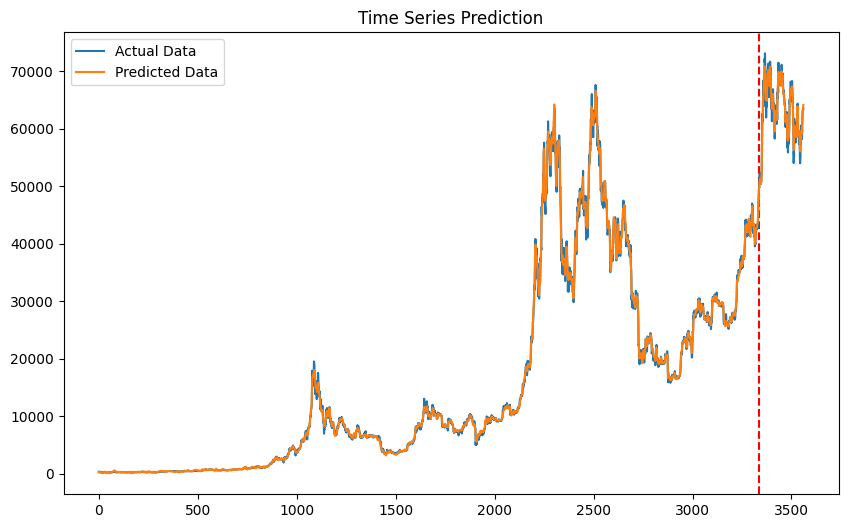

In [101]:

df_y_mm = mm.transform(btc.close.values.reshape(-1, 1)) # old transformers

# split the sequence
df_x_ss, df_y_mm = split_sequence(df_x_ss, df_y_mm, 100, 50)


#converting to tensors
df_x_ss = torch.Tensor(df_x_ss)
df_y_mm = torch.Tensor(df_y_mm)

# reshaping the dataset
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 100, df_x_ss.shape[2])).to(device)

train_predict = lstm(df_x_ss) # forward pass
data_predict = train_predict.cpu().detach().numpy() # I think this is doing the same thing? not sure

dataY_plot = df_y_mm.cpu().detach().numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []

for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])
    
plt.figure(figsize=(10, 6))
plt.axvline(x=train_test_cutoff, c='r', linestyle='--')

plt.plot(true, label='Actual Data')
plt.plot(preds, label='Predicted Data')
plt.title("Time Series Prediction")

plt.legend()
plt.savefig("whole_plot.png", dpi=300)

plt.show()



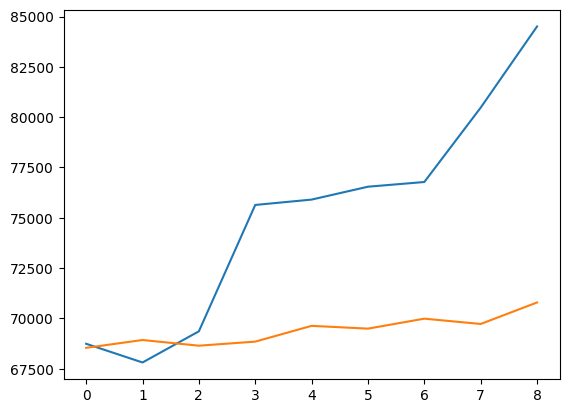

In [102]:
test_predict = lstm(x_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.cpu().detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

test_target = y_test_tensor[-1].detach().cpu().numpy() # last sample 
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0].tolist()

plt.plot(test_target, label='Actual Data')
plt.plot(test_predict, label='Predicted Data')
plt.savefig('small_plot.png', dpi=300)
plt.show()

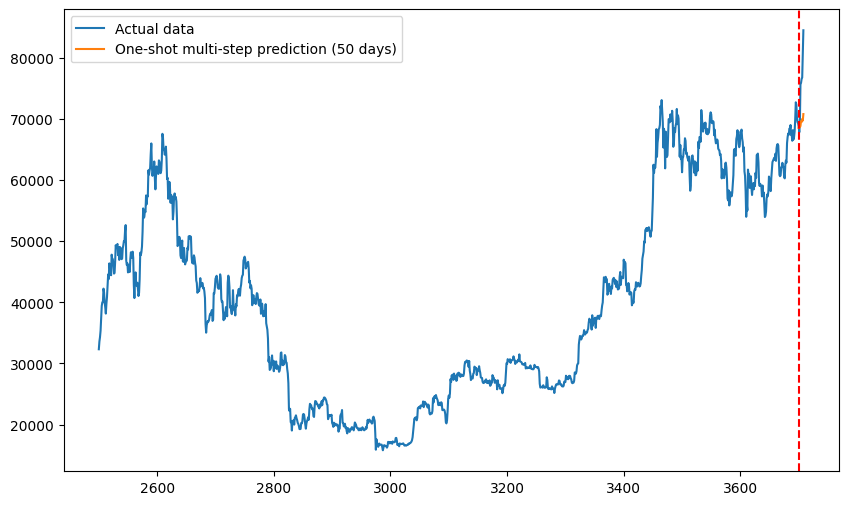

In [104]:
plt.figure(figsize=(10,6)) #plotting
a = [x for x in range(2500, len(y))]
plt.plot(a, y[2500:], label='Actual data')
c = [x for x in range(len(y)-9, len(y))]
plt.plot(c, test_predict, label='One-shot multi-step prediction (9 days)')
plt.axvline(x=len(y)-9, c='r', linestyle='--')
plt.legend()
plt.show()